In [45]:
import random, sys
from scipy import stats
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import time
import math
import matplotlib.pyplot as plt

from numpy.random import Generator, PCG64
from randomgen.aes import AESCounter

rng = Generator(PCG64())
rng = Generator(AESCounter(mode='sequence'))


m = 0b0011111111111101  # modulus, shorter version of yours 0x7ffe1 with a similar concept, also a prime
m = 0xff3d
m = 65537
#m = 131071

def rr(ran, dist=False):  # fully random 16 bits
  a = [0 for _ in range(2**16)] if not dist else [0]*ran
  for i in range(ran):
    x = random.getrandbits(16) 
    if dist:
        a[i] = x
    else:
        a[x] += 1 
  return a


def mm(ran, st=0, dist=False):
  a = [0 for _ in range(m)] if not dist else []
  for i in range(ran): 
    x = random.randint(0, m-1) if st == 0 else (random.getrandbits(st) % m) 
    if dist:
        a.append(x)
    else:
        a[x] += 1 
  return a 
                                                                                                               

def mr(ran, st=0, dist=False): 
  tp = (2**16) // m
  rm = (2**16) - tp * m    
  bd = float(2**16)/m
  mx = (2**16) - 1
  step = 1/(m-1)
  ctr=0
    
  # another idea: monte-carlo rejection sampling-like.
  # offset multiplier: 
    
  a = [0 for _ in range(2**16)] if not dist else [0]*ran
  for i in range(ran): 
    y = random.getrandbits(16) 
    #z = random.getrandbits(st) % m  # not uniform on m
    z = random.randint(0, m-1 - st)  # uniform [0, m-1]
    
    # clear modulus space (no neg. vals), then add
    # problem: absolutely weird shape, like a game logo :D
    #x = (y - m if y >= m else y) + z
    
    # moduli multiplies, resembles distrib, 4*m is only in small counts compared to {0,1,2,3}*m
    # problem: no occurences for 0xfff4+, 4*m and above, and wraps over by adding +z if z > 2**16 - 4m
    #x = (y - (y % m)) + z
    
    # also not working
    #x = (z + (random.getrandbits(2) << 14)) #^ (random.getrandbits(2))
    
    # works: randomized moduli offset, higher only if does not wrap 
    # works for: z = random.getrandbits(st) % m
    #x = (m * random.randint(0, tp if z < rm else tp-1)) + z
#     x = (m * random.randint(0, tp)) + z
#     if x > 0xffff:
#         ctr += 1
#         continue

    x = z & mx
    
    #x = int(rng.uniform(0, bd) * m + rng.integers(0,m))  # try this in spreader
    
    # reversed - down sampled from uniform dist. up - from z/m, rounded to strip precision
    
    # inverse sampling - bit weird
#     u = (z / (m-1)) / 10
#     cr = random.randint(0, 9) / 10
#     x = round((u + cr) * mx)
    
#     # inverse sampling, works only for mod < 2**50
#     u = (z / (m-1))
#     cr = random.uniform(0, step)
#     x = int((u + cr) * mx)
    
    # inverse sampling, just different naming
#     u = random.uniform(0, step)
#     c = (z / (m-1))
#     x = int((c + u) * mx)
    
    if x > 0xffff:  # should not happen, skews distribution
        ctr += 1#sys.stdout.write('.')
        continue
    
    if dist:
        a[i] = x & 0xffff
    else:
        a[x & 0xffff] += 1 
  print('over the top: %s' % (ctr,))      
  return a 

In [15]:
rvs1 = rr(2**24, dist=True)
rvs3 = rr(2**24, dist=True)

In [46]:
# rvs1 = rr(2**16, dist=True)
# rvs2 = rr(2**16, dist=True)

#rvs1 = mm(2**22, dist=True)
#rvs2 = mm(2**22, 14, dist=True)

# rvs1 = rr(2**22, dist=True)
# rvs2 = mm(2**22, 14, dist=True)

# rvs1 = rr(2**20, dist=True)
# rvs2 = mr(2**20, 0, dist=True)
# print('computing KS...')
# print(stats.ks_2samp(rvs1, rvs2))

rvs2 = mr(2**24, 0, dist=True)

print('Computing stats')
print(stats.ks_2samp(rvs1, rvs2))
print(stats.ks_2samp(rvs1, rvs3))
print(stats.ttest_ind(rvs1, rvs2))
print(stats.ttest_ind(rvs1, rvs3))

over the top: 0
Computing stats
KstestResult(statistic=0.0002639293670654297, pvalue=0.6028557013584463)
KstestResult(statistic=0.00036531686782836914, pvalue=0.21281472034758264)
Ttest_indResult(statistic=0.37069324817476995, pvalue=0.710866022136178)
Ttest_indResult(statistic=0.9795270710461964, pvalue=0.32731962652336366)


Generating distribution 1623405099.2451184
over the top: 0
Distribution generated 1623405158.981588


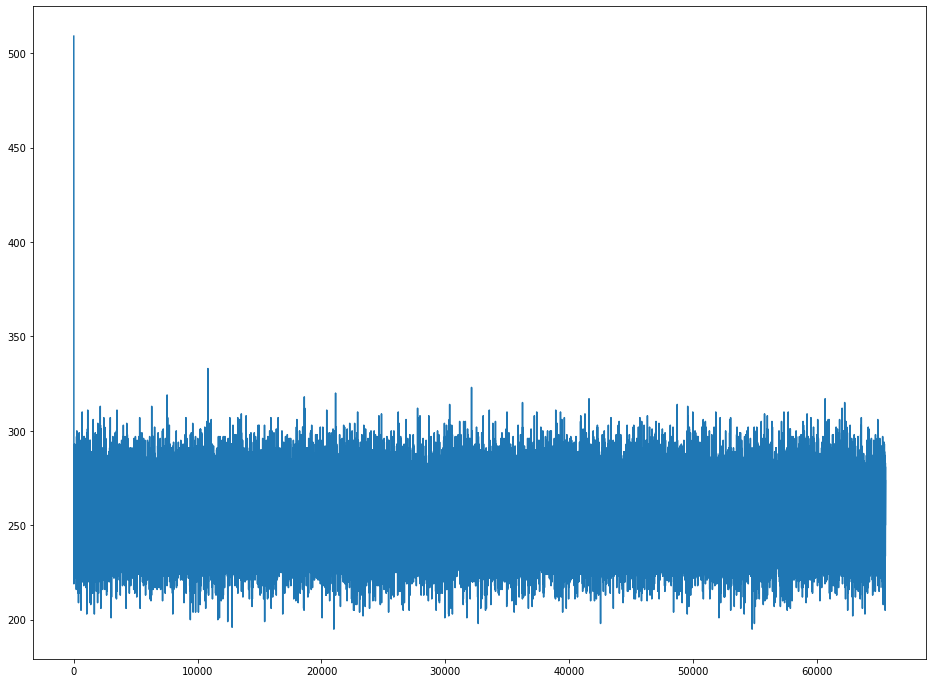

Graph generated 1623405167.129506


In [47]:
print('Generating distribution', time.time())
am = mr(2**24, st=0); 
print('Distribution generated', time.time())

plt.figure(figsize=(16, 12))
sns.lineplot(x=list(range(2**16)), y=am)
plt.show()
print('Graph generated', time.time())

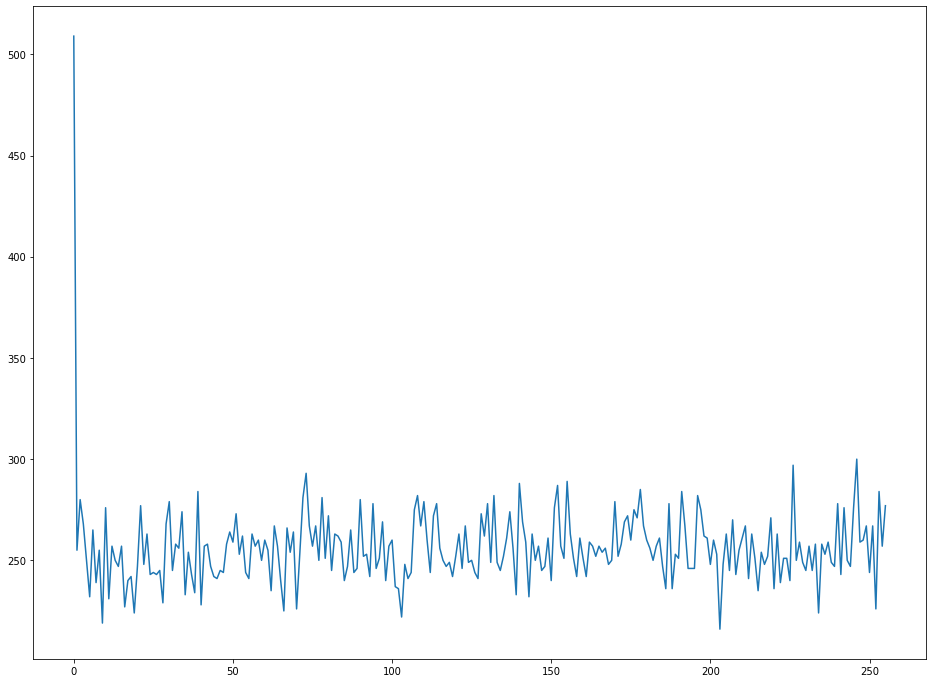

In [48]:
plt.figure(figsize=(16, 12))
sns.lineplot(x=list(range(2**8)), y=am[:2**8])
plt.show()

In [49]:
ctr = 0
for i,x in enumerate(am):
    if x < 150:
        ctr += 1
        print("i: %6d, bin: %16s, hex: %06x, ctr: %s" % (i, (bin(i)[2:]).rjust(16,'0'), i, x))
    if ctr > 200:
        break

In [13]:
hex(m),m

('0x3ffd', 16381)

In [152]:
mmod = 0x73eda753299d7d483339d80809a1d80553bda402fffe5bfeffffffff00000001
math.log(3*mmod,2)

256.44205191376835

In [189]:
from collections import Counter

#step = 1/(m-1)
step = 1/(m)

ta = []#[int((0*step + random.uniform(0, step)) * ((2**16) - 1)) for _ in range(10000)]
tb = []#[int((1*step + random.uniform(0, step)) * ((2**16) - 1)) for _ in range(10000)]
tc = []#[int((2*step + random.uniform(0, step)) * ((2**16) - 1)) for _ in range(10000)]
tw = [int(((m-2)*step + random.uniform(0, step)) * ((2**16) - 1)) for _ in range(10000)]
tu = [int(((m-1)*step + random.uniform(0, step)) * ((2**16) - 1)) for _ in range(10000)]
#print(ta)

ctr = Counter(ta+tb+tc+tw+tu)
for x in sorted(ctr.keys()):
    print('%7d: %5d' % (x, ctr[x]))


  65526:     3
  65527:  2525
  65528:  2497
  65529:  2540
  65530:  2436
  65531:  2440
  65532:  2566
  65533:  2538
  65534:  2455


In [183]:
(2**16)*step

4.000976800976801

In [185]:
1/(2**16/(m-1))

0.24993896484375

In [186]:
(m-1)/(2**16)

0.24993896484375